In [ ]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.13.1


In [ ]:
warnings.filterwarnings('ignore')
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model

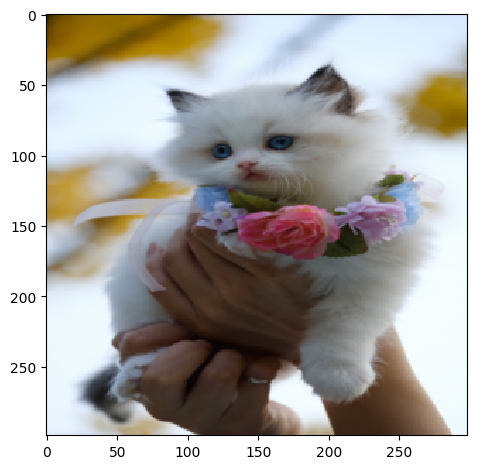

In [ ]:
Xi = skimage.io.imread("/content/pexels-peng-louis-1643457.jpg")
Xi = skimage.transform.resize(Xi, (299,299))
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [ ]:
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes

35363/35363 [==============================] - 0s 0us/step


[('n02123394', 'Persian_cat', 0.83870673),
 ('n02328150', 'Angora', 0.01636231),
 ('n02086079', 'Pekinese', 0.004639813),
 ('n02112018', 'Pomeranian', 0.0038400234),
 ('n07615774', 'ice_lolly', 0.0030662892)]

In [ ]:
#lIME explanation

In [ ]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes

array([283, 332, 154, 259, 929])

In [ ]:
#pertubating the image
#gementing image into regions and will manipulate them

superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

45

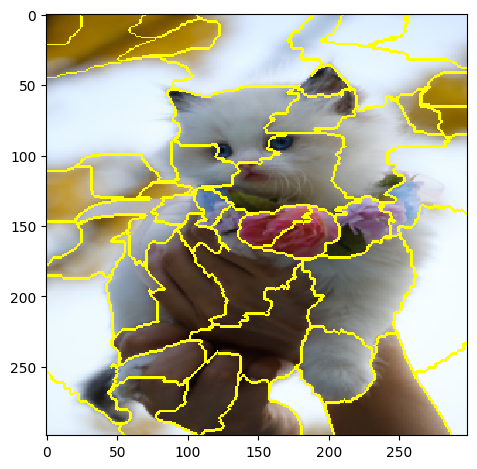

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

#these are 45 pertubations

In [ ]:
#we are creating 150 datapoints
#each having 45 correspoding values for change that segment

num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0],perturbations.shape

(array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0]),
 (150, 45))

In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

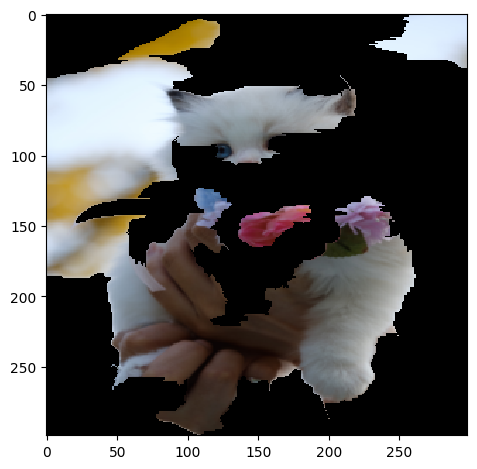

In [ ]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

1/1 [==============================] - 0s 23ms/step


(150, 1, 1000)

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [ ]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.01427554,  0.03053888, -0.05452229,  0.08601952,  0.02483308,
       -0.01084063,  0.02883414,  0.04582528,  0.0084054 ,  0.34189181,
        0.04693747, -0.0144406 ,  0.01538023,  0.04784822,  0.19390189,
        0.1940338 ,  0.21447183, -0.00354285,  0.01239799, -0.0097904 ,
       -0.0170653 ,  0.02339332, -0.07295632, -0.0315583 , -0.01253296,
       -0.04072819, -0.00214813,  0.00083128,  0.00678896,  0.0639121 ,
       -0.04931787, -0.04920857, -0.08595755,  0.05867058,  0.01282915,
       -0.02964858,  0.17839279,  0.01494326,  0.09101085, -0.00728703,
       -0.08348237, -0.01509504,  0.00250211, -0.01154189, -0.01714587])

In [ ]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:]
top_features

array([14, 15, 16,  9])

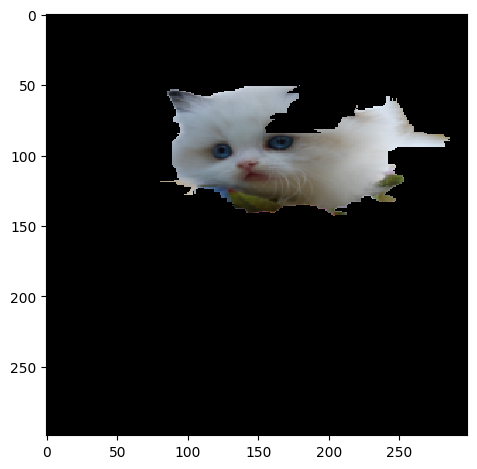

In [ ]:
mask = np.zeros(num_superpixels)
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )